In [9]:
#Import libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn import pipeline as pip
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline, Parallel
from sklearn import naive_bayes as nb
from sklearn import preprocessing as pre
from sklearn import decomposition as dec
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn import model_selection as mod
from sklearn import discriminant_analysis as dis
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text as txt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.casual import casual_tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize, MWETokenizer, regexp_tokenize, WhitespaceTokenizer, NLTKWordTokenizer
from sqlalchemy import create_engine, select, sql, text, column, Table, MetaData, schema

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ali.arslan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
#Data Import

y = pd.read_csv('generation_data.csv', parse_dates=['DateTime'], index_col=["DateTime"])
X = pd.read_csv('X_imputed.csv', parse_dates=['DateTime'], index_col=["DateTime"])
sample_submission = pd.read_csv("sample_submission.csv")

In [11]:
X.columns = [i.replace(' ', '_').replace("'", '').replace(',', '') for i in X.columns]

In [12]:
wwcode_descr = pd.read_excel('wwcode_description.xlsx')
wwcode_descr.head()

,WWCode,Description
0,0,Cloud development not observed or not observable
1,1,Cloud generally dissolving or becoming less de...
2,2,State of sky on the whole unchanged
3,3,Clouds generally forming or developing
4,4,Visibility reduced by smoke


In [13]:
wwcode_descr_dict = {}
for code, desc in zip(wwcode_descr["WWCode"],wwcode_descr["Description"]):
    wwcode_descr_dict[code] = desc
wwcode_descr_dict

{0: 'Cloud development not observed or not observable',
 1: 'Cloud generally dissolving or becoming less developed',
 2: 'State of sky on the whole unchanged',
 3: 'Clouds generally forming or developing',
 4: 'Visibility reduced by smoke',
 5: 'Haze',
 6: 'Widespread dust in suspension in the air',
 7: 'Dust or sand raised by wind at or near the station',
 8: 'Well-developed dust or sand whirl(s)',
 9: 'Duststorm or sandstorm within sight or at the station',
 10: 'Mist',
 11: 'Patches of shallow fog or ice fog at the station',
 12: 'More or less continuous shallow fog or ice fog at the station',
 13: 'Lightning visible, no thunder heard',
 14: 'Precipitation within sight, not reaching the ground',
 15: 'Precipitation within sight, reaching the ground > 5 km from the station',
 16: 'Precipitation within sight near to, but not at the station',
 17: 'Thunderstorm, but no precipitation',
 18: 'Squalls at or within sight of the station',
 19: 'Funnel clouds at or within sight of the statio

In [14]:
X["wwcode_description"] = X["WWCode"].map(wwcode_descr_dict)

In [15]:
stop_words = set(stopwords.words('english'))
stop_words.add('and/or')

In [32]:
#Create Custom Tokenizer & build pipeline for TFIDF vectorizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def CustomTokenizer(d):
    tokens = word_tokenize(d)            
    lemmatizer = WordNetLemmatizer()
    r = []
    for token in tokens:
        if token not in stop_words:
            pt = get_wordnet_pos(token)
            token = lemmatizer.lemmatize(token, pt)
            if len(token) >= 2:
                r.append(token)
    return r

def sparsetoDense(df):
    return df.todense()

pipe = pip.Pipeline([
        ("vect", txt.TfidfVectorizer(tokenizer=CustomTokenizer, lowercase=True, ngram_range=(3, 3), smooth_idf=True, max_df=0.85, min_df= 0.01)),
        ("todense", pre.FunctionTransformer(sparsetoDense))
])

In [33]:
# Transform
X_transformed = pipe.fit_transform(X["wwcode_description"])
pipe.named_steps["vect"].get_feature_names()

['become less developed',
 'cloud development observe',
 'cloud generally dissolve',
 'cloud generally form',
 'development observe observable',
 'dissolve become less',
 'dust suspension air',
 'fall snowflake slight',
 'freeze intermittent slight',
 'generally dissolve become',
 'generally form develop',
 'hail rain snow',
 'moderate without hail',
 'rain freeze intermittent',
 'rain shower slight',
 'sky whole unchanged',
 'slight moderate without',
 'state sky whole',
 'thunderstorm slight moderate',
 'visibility reduce smoke',
 'widespread dust suspension',
 'without hail rain']

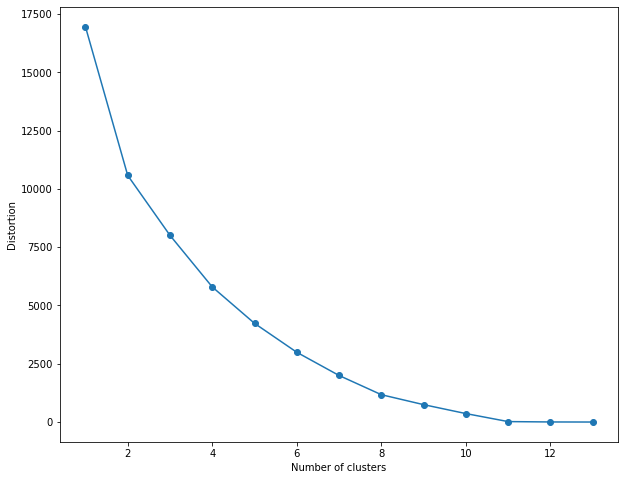

In [68]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 14):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=500,
        tol=1e-04, random_state=421
    )
    km.fit(X_transformed)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(10, 8))
plt.plot(range(1, 14), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [69]:
km = KMeans(
    n_clusters=11, init='k-means++',
    n_init=10, max_iter=500, 
    tol=1e-04, random_state=421
)
wwcode_km_cluster = km.fit_predict(X_transformed)

wwcode_km_cluster

array([0, 0, 0, ..., 5, 3, 4])

In [70]:
X["wwcode_cluster"] = wwcode_km_cluster
X_tfidf = pd.DataFrame(X_transformed, columns=pipe.named_steps["vect"].get_feature_names(), index=X.index)
X.merge(X_tfidf, left_index=True, right_index=True, how='left').describe().T

,count,mean,std,min,25%,50%,75%,max
AirTemperature,26304.0,13.741522,9.379876,-13.1,6.00,13.4,21.000000,39.000000
ComfortTemperature,26304.0,13.239397,9.767058,-19.3,5.10,13.0,21.200000,37.200000
RelativeHumidity,26304.0,54.352832,22.566688,1.6,36.60,55.1,72.500000,100.000000
WindSpeed,26304.0,1.655931,1.353196,0.0,0.50,1.5,2.600000,13.400000
WindDirection,26304.0,87.463960,100.762932,0.0,20.00,30.0,170.000000,360.000000
WWCode,26304.0,11.384542,23.067932,0.0,0.00,2.0,6.000000,99.000000
EffectiveCloudCover,26304.0,2.614051,2.497609,0.0,0.00,2.1,5.000000,8.000000
is_holiday,26304.0,0.038321,0.191974,0.0,0.00,0.0,0.000000,1.000000
Hour,26304.0,11.500000,6.922318,0.0,5.75,11.5,17.250000,23.000000
DayGroup,26304.0,0.750000,1.050813,0.0,0.00,0.0,2.000000,3.000000


In [71]:
X_new = X.merge(X_tfidf, left_index=True, right_index=True, how='left')
X_new["Day"] = [day for day in X_new.index.day]
#X_new = X_new.drop('wwcode_description', axis=1)

In [72]:
X_new.pivot_table(index=['WWCode','wwcode_description'], values='wwcode_cluster', aggfunc='mean').fillna(0)

,,wwcode_cluster
WWCode,wwcode_description,
0.0,Cloud development not observed or not observable,1
1.0,Cloud generally dissolving or becoming less developed,6
2.0,State of sky on the whole unchanged,3
3.0,Clouds generally forming or developing,2
4.0,Visibility reduced by smoke,4
5.0,Haze,0
6.0,Widespread dust in suspension in the air,5
7.0,Dust or sand raised by wind at or near the station,0
8.0,Well-developed dust or sand whirl(s),0


In [73]:
#write to csv
X_new.to_csv("X_wwcode_clusters.csv")